The suscpetible-infected-recovered (SIR) model is a system of nonlinear ODEs given by
\begin{align}
    \frac{dS}{dt} &= \mu N - \mu S - \eta k I S \\
    \frac{dI}{dt} &= \eta k I S - (\gamma+\mu)I \\
    \frac{dR}{dt} &= \gamma I - \mu R.
    \end{align}

where $\gamma$ is the infection rate, $k$ is the contact rate, $r$ is the recovery rate, and $mu$ represents the collective birth and death rate. Each parameter is assumed to take values in the interval [0,1].


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import uniform, beta, gaussian_kde


In [2]:
# SIR model function
def SIR_model(y, t, params, N):
    # Unpack parameters
    gamma, k, r, mu = params
    # Redefine state variables
    S, I, R = y

    # RHS equations
    dSdt = mu*N - mu*S - gamma*k*I*S
    dIdt = gamma*k*I*S - (r + mu)*I
    dRdt = r*I - mu*R
    return [dSdt, dIdt, dRdt]


In [3]:
# Initial conditions for the SIR model
S0, I0, R0 = 900, 100, 0
X0 = [S0, I0, R0]
N = np.sum(X0)

# Time variables
t_final = 50
dt = 0.05
t_data = np.arange(0, t_final + dt, dt)

ode_options = {'rtol': 1e-6}

# Quantities of interest: integral of the infected state and steady-state equilibrium value of the infected state
QoI_time = len(t_data)
Y0 = np.array([S0, I0, R0])

# Identify upper and lower bounds for [gamma, k, r, mu]
parameter_names = ['gamma', 'k', 'r', 'mu']
UB = np.array([0.3, 1.0, 1.0, 0.5])
LB = np.array([0.1, 0.1, 0.1, 0.1])

par_all = 0.5 * (UB + LB)

# Parameters
par_nom = par_all
pars = par_all
num_par = len(UB)

# Number of samples, parameters, levels, and step size
M = 2000
p = num_par
delta = 1e-6
upper = UB
lower = LB
d = np.zeros((M, p))

# Storage
F_storage = np.zeros((p + 1, M))
mean_value = 0
mean_sq_value = 0
qcurr = np.zeros((M, p))
for j in range(4):
    qcurr[:, j] = np.random.uniform(LB[j] + delta, UB[j] - delta, M)



In [4]:
for i in range(M):
    fbase = odeint(SIR_model, Y0, t_data, args=(qcurr[i, :], N), **ode_options)
    F_storage[0, i] = fbase[-1, 2]
    mean_value += fbase[-1, 2]
    mean_sq_value += fbase[-1, 2]**2
    
    for j in range(p):
        par_plus = qcurr[i, :].copy()
        par_plus[j] += delta
        fstep = odeint(SIR_model, Y0, t_data, args=(par_plus, N), **ode_options)
        d[i, j] = (fstep[-1, 2] - fbase[-1, 2]) / delta
        F_storage[j, i] = fstep[-1, 2]
        mean_value += fstep[-1, 2]
        mean_sq_value += fstep[-1, 2]**2

# Calculate the variance of all the outputs
mean_value /= (M * (p + 1))
mean_sq_value /= (M * (p + 1))

mu = np.sum(d, axis=0) / M
mu_star = np.sum(np.abs(d), axis=0) / M
v = np.sum(d**2, axis=0) / M
var_out = mean_sq_value - mean_value**2

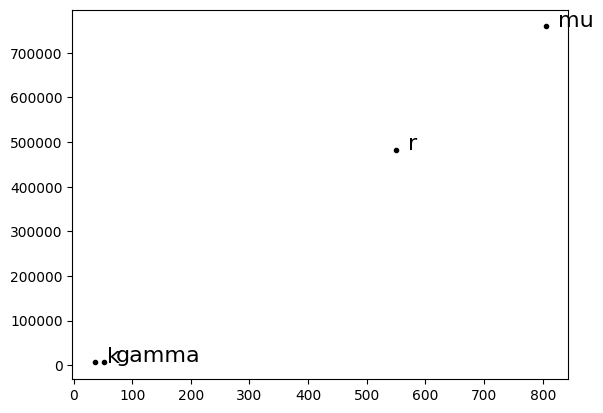

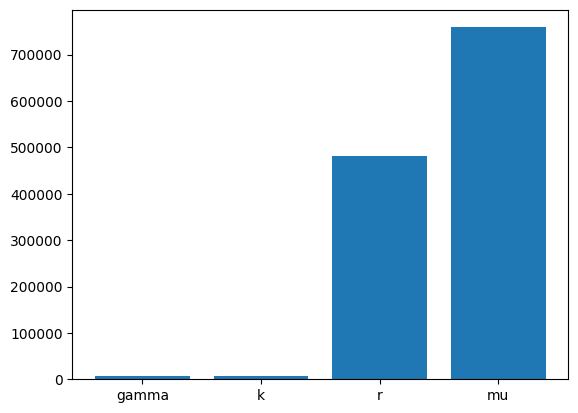

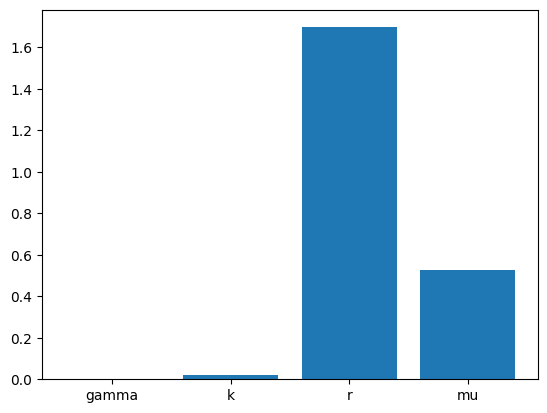

In [6]:
plt.figure()
for i in range(num_par):
    plt.plot(mu_star[i], v[i], 'k.', markersize=6)
    plt.text(mu_star[i] + 20, v[i], parameter_names[i], fontsize=16)
plt.show()

poincare_const = (UB - LB)**2 / (np.pi**2)
plt.figure()
plt.bar(range(len(v)), v)
plt.xticks(range(len(v)), parameter_names)
plt.show()

plt.figure()
plt.bar(range(len(v)), poincare_const * v / var_out)
plt.xticks(range(len(v)), parameter_names)
plt.show()